In [40]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from nltk.metrics.distance import jaccard_distance
import spacy
import sys
import os
from nltk import CFG, ChartParser, TopDownChartParser, BottomUpChartParser, BottomUpLeftCornerChartParser, LeftCornerChartParser
import svgling

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from textserver import TextServer
import config

In [30]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')

nlp = spacy.load("en_core_web_sm")


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package maxent_ne_chunker_tab is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/zachparent/nltk_data...
[nltk_data]   Package words is already up-to-date!


|.  small  .   cats  .   and   .   mice  .|
|[---------]         .         .         .| [0:1] 'small'
|.         [---------]         .         .| [1:2] 'cats'
|.         .         [---------]         .| [2:3] 'and'
|.         .         .         [---------]| [3:4] 'mice'
|[---------]         .         .         .| [0:1] JJ -> 'small' *
|[--------->         .         .         .| [0:1] NP -> JJ * NNS
|.         [---------]         .         .| [1:2] NNS -> 'cats' *
|.         [---------]         .         .| [1:2] NP -> NNS *
|.         [--------->         .         .| [1:2] NNS -> NNS * CC NNS
|[-------------------]         .         .| [0:2] NP -> JJ NNS *
|[------------------->         .         .| [0:2] NP -> NP * CC NP
|.         [--------->         .         .| [1:2] NP -> NP * CC NP
|.         .         [---------]         .| [2:3] CC -> 'and' *
|.         [------------------->         .| [1:3] NNS -> NNS CC * NNS
|[----------------------------->         .| [0:3] NP -> NP CC * NP

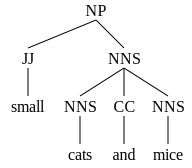

In [55]:
sent = "small cats and mice"
grammar = CFG.fromstring('''
  NP  -> NNS | JJ NNS | NP CC NP
  NNS -> "cats" | "dogs" | "mice" | NNS CC NNS 
  JJ  -> "big" | "small"
  CC  -> "and" | "or"
  ''')
parser = ChartParser(grammar, trace=1)
parse = parser.parse(sent.split())
ts = list(parse)
'{num} trees.'.format(num=len(ts))
chart = ts[0]
chart

In [57]:
chart.num_edges()

AttributeError: 'Tree' object has no attribute 'num_edges'

In [35]:
parse.edges()

[[Edge: [0:1] 'small'],
 [Edge: [1:2] 'cats'],
 [Edge: [2:3] 'and'],
 [Edge: [3:4] 'mice'],
 [Edge: [0:1] JJ -> 'small' *],
 [Edge: [0:1] NP -> JJ * NNS],
 [Edge: [1:2] NNS -> 'cats' *],
 [Edge: [1:2] NP -> NNS *],
 [Edge: [1:2] NNS -> NNS * CC NNS],
 [Edge: [0:2] NP -> JJ NNS *],
 [Edge: [0:2] NP -> NP * CC NP],
 [Edge: [1:2] NP -> NP * CC NP],
 [Edge: [2:3] CC -> 'and' *],
 [Edge: [1:3] NNS -> NNS CC * NNS],
 [Edge: [0:3] NP -> NP CC * NP],
 [Edge: [1:3] NP -> NP CC * NP],
 [Edge: [3:4] NNS -> 'mice' *],
 [Edge: [3:4] NP -> NNS *],
 [Edge: [3:4] NNS -> NNS * CC NNS],
 [Edge: [1:4] NNS -> NNS CC NNS *],
 [Edge: [1:4] NP -> NNS *],
 [Edge: [1:4] NNS -> NNS * CC NNS],
 [Edge: [0:4] NP -> JJ NNS *],
 [Edge: [0:4] NP -> NP * CC NP],
 [Edge: [1:4] NP -> NP * CC NP],
 [Edge: [3:4] NP -> NP * CC NP],
 [Edge: [0:4] NP -> NP CC NP *],
 [Edge: [1:4] NP -> NP CC NP *]]

In [45]:
ts = list(parse)
'{num} trees.'.format(num=len(ts))


'0 trees.'

In [46]:
ts[0]

IndexError: list index out of range

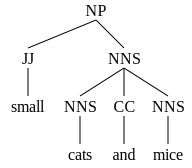

In [21]:
parser = nltk.TopDownChartParser(grammar)
parse = parser.parse(sent.split())
ts= list(parse)
'{num} trees.'.format(num=len(ts))
ts[0]


<class 'nltk.parse.chart.TopDownChartParser'>


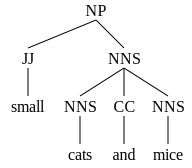

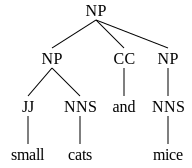

<class 'nltk.parse.chart.BottomUpChartParser'>


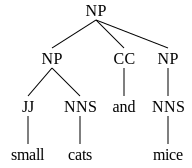

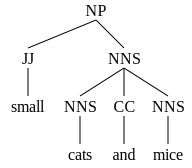

<class 'nltk.parse.chart.BottomUpLeftCornerChartParser'>


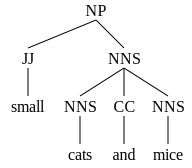

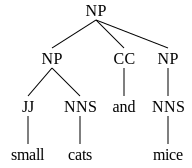

<class 'nltk.parse.chart.LeftCornerChartParser'>


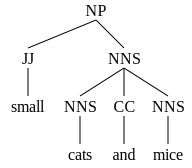

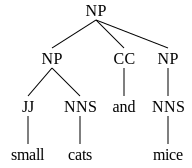

,parser,num_trees,edges
0,TopDownChartParser,2,"[[0:1] 'small', [1:2] 'cats', [2:3] 'and', [3:..."
1,BottomUpChartParser,2,"[[0:1] 'small', [1:2] 'cats', [2:3] 'and', [3:..."
2,BottomUpLeftCornerChartParser,2,"[[0:1] 'small', [1:2] 'cats', [2:3] 'and', [3:..."
3,LeftCornerChartParser,2,"[[0:1] 'small', [1:2] 'cats', [2:3] 'and', [3:..."


In [77]:
grammar = CFG.fromstring('''
  NP  -> NNS | JJ NNS | NP CC NP
  VP  -> VBP NP | VBP CC NP | VP
  NNS -> "cats" | "dogs" | "mice" | NNS CC NNS 
  JJ  -> "big" | "small" | "lazy"
  CC  -> "and" | "or" | "with"
  VBP -> "play"
  ''')

sent = "small cats and mice"

parsers = [TopDownChartParser, BottomUpChartParser, BottomUpLeftCornerChartParser, LeftCornerChartParser]
# parsers = [TopDownChartParser]
chart_stats = []

for parser_class in parsers:
    print(parser_class)
    parser = parser_class(grammar)
    chart = parser.chart_parse(sent.split())  # Use chart_parse instead of parse
    trees = list(chart.parses(grammar.start()))
    for tree in trees:
        display(svgling.draw_tree(tree))
    chart_stats.append({
        "parser": parser_class.__name__,
        "num_trees": len(trees),
        "edges": chart.edges()
    })

chart_stats = pd.DataFrame(chart_stats)
chart_stats


TopDownChartParser


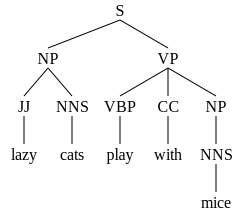

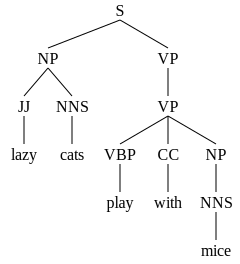

BottomUpChartParser


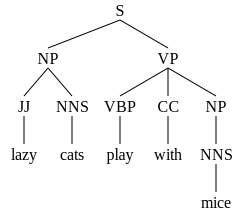

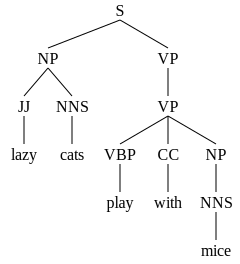

BottomUpLeftCornerChartParser


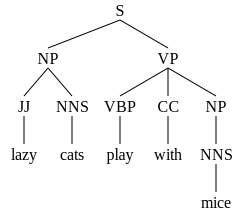

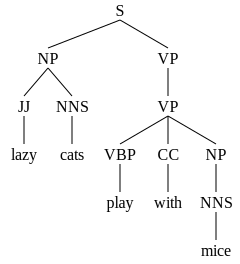

LeftCornerChartParser


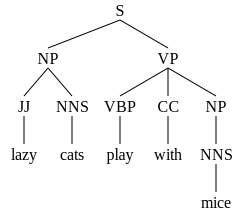

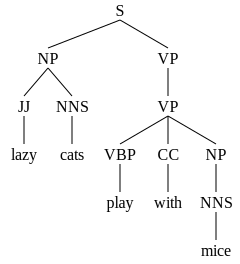

,parser,num_trees,edges
0,TopDownChartParser,2,"[[0:1] 'lazy', [1:2] 'cats', [2:3] 'play', [3:..."
1,BottomUpChartParser,2,"[[0:1] 'lazy', [1:2] 'cats', [2:3] 'play', [3:..."
2,BottomUpLeftCornerChartParser,2,"[[0:1] 'lazy', [1:2] 'cats', [2:3] 'play', [3:..."
3,LeftCornerChartParser,2,"[[0:1] 'lazy', [1:2] 'cats', [2:3] 'play', [3:..."


In [80]:
grammar = CFG.fromstring('''
  S  -> NP VP
  NP  -> NNS | JJ NNS | NP CC NP
  VP  -> VBP NP | VBP CC NP | VP
  NNS -> "cats" | "dogs" | "mice" | NNS CC NNS 
  JJ  -> "big" | "small" | "lazy"
  CC  -> "and" | "or" | "with"
  VBP -> "play"
  ''')

sent = "lazy cats play with mice"

parsers = [TopDownChartParser, BottomUpChartParser, BottomUpLeftCornerChartParser, LeftCornerChartParser]
# parsers = [TopDownChartParser]
chart_stats = []

for parser_class in parsers:
    print(parser_class.__name__)
    parser = parser_class(grammar)
    chart = parser.chart_parse(sent.split())  # Use chart_parse instead of parse
    trees = list(chart.parses(grammar.start()))
    for tree in trees:
        display(svgling.draw_tree(tree))
    chart_stats.append({
        "parser": parser_class.__name__,
        "num_trees": len(trees),
        "edges": chart.edges()
    })

chart_stats = pd.DataFrame(chart_stats)
chart_stats


first line in chartparser input is the root

only add rules to exisiting ruleset